In [77]:
# csce478    Programming Assignment 4     Fall 2020                                   Due: Nov 17 11am
# Linear Support Vector Machine & Principle Component Analysis
# Contributers: Chungsum Kim, Devn Steiner, Jesse Reyes Cortes

#imported packages
import pandas as pd
import numpy as np
import math
import copy
import itertools
from random import sample 
import nltk
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from random import seed
seed(.5)
from random import random
import numpy as np
from numpy.linalg import eig
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.image as image 
import matplotlib.pyplot as plt

# helper functions
def accuracy(x,y):
    count = 0
    for i in range(0, len(x)):
        if(x[i]==1 and .5 < y[i]):
            count = count + 1
        elif(x[i]==0 and y[i] < .5):
            count = count + 1
    
    return count/len(x)


def confusion_matrix(x,y):
    TN = 0
    FP = 0
    FN = 0
    TP = 0
    for i in range(0, len(y)):
        if(x[i]==0 and y[i] <= .5):
            TN = TN + 1
        elif(x[i]==0 and .5 < y[i]):
            FP = FP + 1
        elif(x[i]==1 and y[i] <= .5):
            FN = FN + 1
        elif(x[i]==1 and .5 < y[i]):
            TP = TP + 1

    return [[TN, FP],[FN, TP]]



def kFoldHelper(X,Y, k):
    
    kData = []
    x = np.array_split(X,k)
    y = np.array_split(Y,k)
    
    for i in range(0, k):
        x_train = pd.DataFrame([])
        y_train = pd.DataFrame([])
        x_test = np.array(x[i])
        y_test = np.array(x[i])
        for j in range(0,k):
            if i != j:
                x_train = x_train.append(pd.DataFrame(x[j]))
                y_train = y_train.append(pd.DataFrame(y[j]))

        kData.append([np.array(x_train),np.squeeze(np.array(y_train)),x_test,y_test])
    
    return kData


In [276]:
# Part A : Linear Support Vector Machine (SVM)

# A.1 implement Linear_SVC model class for performing binary classification

class Linear_SVC:
    def __init__(self, C=1, max_iter=100, tol=None, learning_rate="constant",learning_rate_init=0.001, t_0=3, t_1=1, early_stopping=False, validation_fraction=0.1, **kwargs):
        self.C = C
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init
        self.t_0 = t_0
        self.t_1 = t_1
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.cost = np.array([])
        self.svs = np.array([])
        
        
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        
        # use to find labels for support vectors
        t = self.Y * 2 - 1
        
        # calculate the weight vector w with length of one sample with random small number
        self.w = np.array([[random()], [random()]])
        
        # intercept bias b originally set to 0
        self.b = 0
        
        # iterate 0 - max_iter unless stopped early
        for i in range(0, self.max_iter):
            
            # determine which are the support vectors & their labels
            svs = (t.reshape(-1,1) * (self.X.dot(self.w) + self.b) < 1).ravel()
            x_sv = self.X[svs]
            t_sv = t[svs]
            
            # compute primary form
            prim_form = (1/2) * np.matmul(self.w.reshape(1,2),self.w)

            j = abs(prim_form + self.C * (np.sum((1-x_sv.dot(self.w)) - self.b) * np.sum(t_sv)))
            
            self.cost = np.append(self.cost, [j])
            
            # early stopping
            if (self.early_stopping ==True and j < self.tol):
                break
                
            grad_w = self.w - self.C * np.array([[np.sum(x_sv[:,0])], [np.sum(x_sv[:,1])]])
            
            grad_b = -self.C * np.sum(t_sv)
            
            # determine the correct learning rate
            lr = self.learning_rate_init
            
            if self.learning_rate == "adaptive":
                lr = self.t_0/(i + self.t_1)
            
            #update gradients
            self.w = self.w - lr * grad_w
            self.b = self.b - lr * grad_b
            
            #update support vectors
            self.svs = x_sv
        
        return self
            
        
    def predict(self, X):
        
        y_hat = np.array([])
        
        for i in range(0, len(X)):
            
            if self.w.reshape(1,2).dot(X[i].reshape(2,1)) + self.b >= 0:
                y_hat = np.append(y_hat, [1])
            else:
                y_hat = np.append(y_hat, [0])
        
        
        return y_hat
        
    def plot_curve(self):
        
        plt.title('Learning Curve')
        plt.plot(np.arange(len(self.cost)),self.cost, label="Learning Curve", color='orange')
        plt.legend(loc = 'lower right')
        plt.ylabel('Learning Rate')
        plt.xlabel('Iteration')
        plt.legend()
        plt.show()
        
        
        
        
        

In [277]:
# Binary Classification using Linear_SVC Classifier

# A.2 read the iris data, X features: petal length & petal width, recode binary target such that Iris-Virginica is 1 or 0
data = load_iris()

pl = data["data"][:,2]
pw = data["data"][:,3]
X = np.zeros((len(pl), 2))
X[:,0] = pl
X[:,1] = pw


Y = np.where(data['target'] == 2, 1, 0)

In [278]:
# A.3 partition data into train & test set (80% - 20%)
def partition(X, Y, t):     
    test_size = math.ceil(len(Y)*t)
    training_size = len(Y)-test_size
    training_data = X[0:training_size][:]
    testing_data = X[training_size+1:len(Y)] [:]
    training_vector = Y[0:training_size]
    testing_vector = Y[training_size+1:len(Y)]
    
    return training_data, testing_data, training_vector, testing_vector

In [279]:
# A.4 Hyper-parameter training(kFold - C, learning_rate, max_iter, tol)

#testing params
Cs = [2,2.2]
learning_rate_inits = [.1, .10000001]
max_iters = [900, 1000]
tol = [.0001, .01]
learning_rates = ["constant", "adaptive"]

data = kFoldHelper(X, Y, 5)

dict_svm = {"C":[], "learn rate":[], "max iter":[], "tol":[], "learn type":[], "accuracy":[], "confusion matrix":[]}
count = 0
for lr in learning_rates:
    for lri in learning_rate_inits:
        for mi in max_iters:
            for t in tol:
                for c in Cs:
                    y_hat = np.array([])
                    for d in data:
                        
                        x_train = d[0]
                        y_train = d[1]
                        x_test = d[2]
                        y_test = d[3]
                                                
                        model = Linear_SVC(C=c,max_iter=mi,tol=t,learning_rate=lr,learning_rate_init=lri,early_stopping=True)
                        
                        model.fit(x_train,y_train)
                        
                        y_hat = np.append(y_hat, model.predict(x_test))
                    
                    count = 1 + count
                    #update dict
                    dict_svm["C"].append(c)
                    dict_svm["learn rate"].append(lri)
                    dict_svm["max iter"].append(mi)
                    dict_svm["tol"].append(t)
                    dict_svm["learn type"].append(lr)
                    dict_svm["accuracy"].append(accuracy(Y,y_hat))
                    dict_svm["confusion matrix"].append(confusion_matrix(Y,y_hat))

In [280]:
# A.5 train model using optimal values for hyperparameters on test data, report accuracy and test confusion matrix
print(pd.DataFrame(dict_svm))

      C  learn rate  max iter     tol learn type  accuracy  \
0   2.0         0.1       900  0.0001   constant  0.966667   
1   2.2         0.1       900  0.0001   constant  0.980000   
2   2.0         0.1       900  0.0100   constant  0.966667   
3   2.2         0.1       900  0.0100   constant  0.980000   
4   2.0         0.1      1000  0.0001   constant  0.966667   
5   2.2         0.1      1000  0.0001   constant  0.973333   
6   2.0         0.1      1000  0.0100   constant  0.966667   
7   2.2         0.1      1000  0.0100   constant  0.973333   
8   2.0         0.1       900  0.0001   constant  0.966667   
9   2.2         0.1       900  0.0001   constant  0.980000   
10  2.0         0.1       900  0.0100   constant  0.966667   
11  2.2         0.1       900  0.0100   constant  0.980000   
12  2.0         0.1      1000  0.0001   constant  0.966667   
13  2.2         0.1      1000  0.0001   constant  0.973333   
14  2.0         0.1      1000  0.0100   constant  0.966667   
15  2.2 

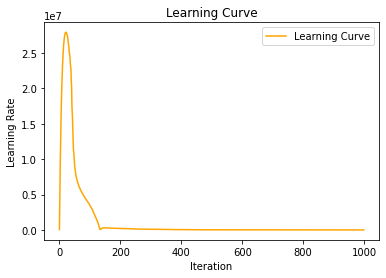

In [175]:
# A.6 plot the learning curve NOT COMPLETED
x_train,x_test, y_train, y_test = partition(X, Y, .20)

model = Linear_SVC(learning_rate_init=.1, max_iter=900, C=2.2)

model.fit(x_train, y_train)

model.plot_curve()

y_hat = model.predict(x_test)

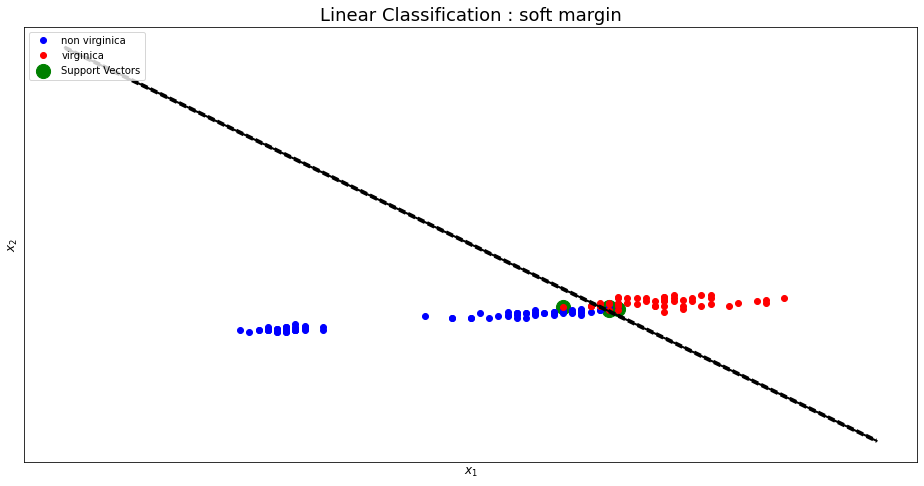

In [176]:
# A.7 plot the decision boundary and show support vectors using “decision_boundary_support_vectors”
# https://github.com/rhasanbd/Support-Vector-Machine-Classifier-Beginners-Survival-Kit/blob/master/Support%20Vector%20Machine-1-Linearly%20Separable%20Data.ipynb
# Draw a scatter plot
def decision_boundary_support_vectors(X, Y):
    
    xmin, xmax = X.min() - 1, X.max() + 1
    
    x_train,x_test, y_train, y_test = partition(X, Y, .20)
    
    model = Linear_SVC(learning_rate_init=0.1, max_iter=1000, C=2.2)

    self = model.fit(x_train, y_train)
    
    # At the decision boundary, w1*x1 + w2*x2 + b = 0
    # => x2 = -(b + w1* x1)/w1
    x1 = np.linspace(xmin, xmax, 100)
    
    decision_boundary = -(self.b + self.w[0]*x1)/self.w[1]

    shifting_factor_for_margin = 1/self.w[1]
    
    upper_margin = decision_boundary + shifting_factor_for_margin
    lower_margin = decision_boundary - shifting_factor_for_margin

#     svs = svm_clf.support_vectors_
    plt.scatter(self.svs[:, 0], self.svs[:, 1], s=200, facecolors='g', label="Support Vectors")
    plt.plot(x1, decision_boundary, "k-", linewidth=2)
    plt.plot(x1, upper_margin, "k--", linewidth=2)
    plt.plot(x1, lower_margin, "k--", linewidth=2)
    

# determine which points are & aren't virginica
virginica =(Y > 0).ravel()
non_virginica = (Y < 1).ravel()

x_v = X[virginica]
x_nv = X[non_virginica]

# Draw a scatter plot
plt.figure(figsize=(16,8))
plt.plot(x_nv[:, 0], x_nv[:, 1], "bo", label="non virginica")
plt.plot(x_v[:, 0], x_v[:, 1], "ro", label="virginica")

decision_boundary_support_vectors(X,Y)

plt.title("Linear Classification : soft margin", fontsize=18)
plt.legend(loc=2)
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", rotation=90, fontsize=12)
plt.xticks(())
plt.yticks(())
plt.show()

In [146]:
# A.8 implement early stopping in the "fit" method of the Linear_SVC model, generate early stopping code


# this implementation was integrated into the Linear_SVM model A.1


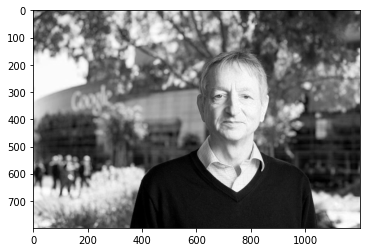

In [9]:
# Part B: Principle Component Analysis

# B.9 using matplotlib.pyploy "imread" function read the image as a 2D matrix
X = plt.imread('Hinton.jpg')[:,:,0] #set RGB value to zero
plt.gray()
plt.imshow(X)

In [10]:
# B.10 implement steps of eigendecomposition based PCA on X
print("X:\n", X)
print("\nX dimension (N x d): ", X.shape)


# Compute the mean of the data (mean of each feature/column)
X_mean = np.mean(X, axis=0)
print("\nMean of X:\n", X_mean )

# (a) Center the data (subtract the mean)
X_centered = X - X_mean
print("\nX Centered:\n", X_centered)


# (b) Compute the covariance matrix of the data
cov_X =  X_centered.T.dot(X_centered)/(X.shape[0]-1)
print("\nCovariance Matrix:\n", cov_X)

# Compute the covariance matrix of the data using NumPy function


print("\nCovariance Matrix (using NumPy):\n", np.cov(X_centered.T))


# (c) find eigenvalues and eigenvectors fo the covariance matrix
eigenvalues, eigenvectors = eig(cov_X)

print("\nEigenvectors (Principle Components):\n", eigenvectors)
print("\nEigenvalues (Variances):\n", eigenvalues)


print("\nObserve that the first PC explains most of the variance (largest eigenvalue) in the data.")

print("\nX dimension: ", X.shape)
print("Covariance matrix dimension: ", cov_X.shape)
print("Eigenvalues dimension: ", eigenvalues.shape)
print("Eigenvectors dimension: ", eigenvectors.shape)


X:
 [[ 94  89  87 ... 132 133 136]
 [ 96  89  84 ... 137 137 140]
 [101  89  84 ... 141 141 143]
 ...
 [234 234 235 ... 148 150 151]
 [230 231 232 ... 145 147 149]
 [229 229 231 ... 145 147 148]]

X dimension (N x d):  (799, 1200)

Mean of X:
 [181.68961202 181.4155194  180.85982478 ... 111.38047559 111.5669587
 111.69461827]

X Centered:
 [[-87.68961202 -92.4155194  -93.85982478 ...  20.61952441  21.4330413
   24.30538173]
 [-85.68961202 -92.4155194  -96.85982478 ...  25.61952441  25.4330413
   28.30538173]
 [-80.68961202 -92.4155194  -96.85982478 ...  29.61952441  29.4330413
   31.30538173]
 ...
 [ 52.31038798  52.5844806   54.14017522 ...  36.61952441  38.4330413
   39.30538173]
 [ 48.31038798  49.5844806   51.14017522 ...  33.61952441  35.4330413
   37.30538173]
 [ 47.31038798  47.5844806   50.14017522 ...  33.61952441  35.4330413
   36.30538173]]

Covariance Matrix:
 [[3516.14915261 3515.75820653 3517.60054705 ... 2319.4753859
  2291.25890446 2275.88253801]
 [3515.75820653 3526.67

In [4]:
# B.11 find top k eigenvectors and create eigen vector matrix using top k eigenvectors
eigenvectors = np.real(eigenvectors)
eigenvalues = np.real(eigenvalues)
value_sort = np.argsort(eigenvalues)[::-1]
eigenvalues_sort = eigenvalues[value_sort]
eigenvectors_sort = eigenvectors[:,value_sort]

In [7]:
# B.12 finally project mean centered data on the k top eigenvectors
def kTopEigenVectors(k):
    topEigenVector = eigenvectors_sort[:,0:k]
    return topEigenVector

print("Testing\n")
top_k_eigenVector = kTopEigenVectors(5)
print(top_k_eigenVector)

Testing

[[ 0.02018943 -0.02933181  0.02887945  0.02245358  0.01245638]
 [ 0.02079739 -0.03007644  0.02878696  0.02175863  0.01319105]
 [ 0.02173152 -0.03130956  0.0288032   0.02033464  0.01471336]
 ...
 [ 0.03603531 -0.03290896  0.00996503 -0.02127322 -0.01772948]
 [ 0.03593338 -0.03252431  0.0098534  -0.02120024 -0.01774252]
 [ 0.03583585 -0.0322487   0.00991514 -0.02118017 -0.01773135]]


In [ ]:
# B.13 reconstruct data matrix by taking dot product between projected data and transpose of top K eigenvec matrix


In [ ]:
# B.14 compute reconstruction error between mean centered data matrix X and reconstructed data matrix



K value:  10
Reconstruction Error:  469.80185123172123


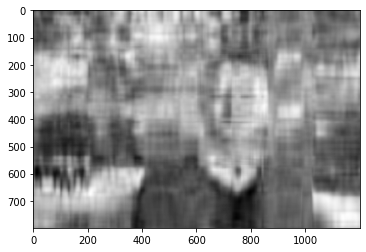


K value:  30
Reconstruction Error:  103.60503214223388


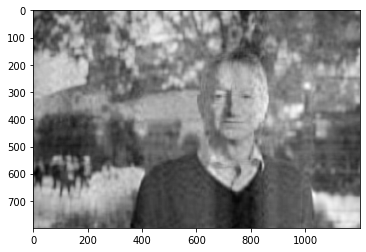


K value:  50
Reconstruction Error:  39.089180841062955


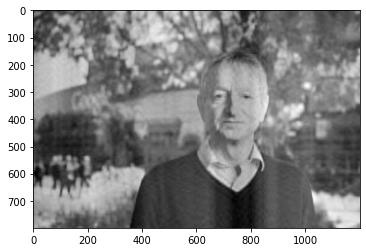


K value:  100
Reconstruction Error:  10.181165118643886


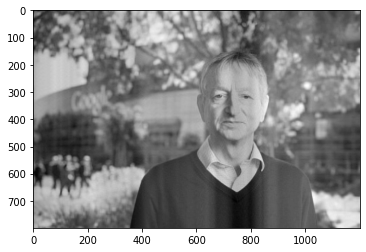


K value:  500
Reconstruction Error:  0.054687816214731566


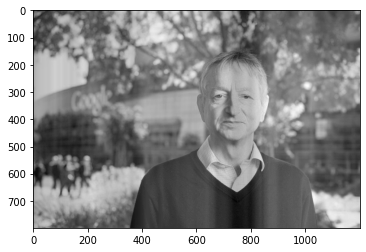

In [11]:
# B.15 perform steps 11-14 for k: 10, 30, 50, 100, 500
# for each k reconstruct image & print the value of k and reconstruction error
#list of k value
k_list = [10,30,50,100,500]

for k in k_list:
    print('\nK value: ', k)
    top_k_vector_value = kTopEigenVectors(k)
    X_projected_k_pc = X_centered.dot(top_k_vector_value)
    X_reconstructed_k_pc = X_projected_k_pc.dot(top_k_vector_value.T)
    reconstruction_error_k_pc = mean_squared_error(X_centered, X_reconstructed_k_pc)
    print('Reconstruction Error: ', reconstruction_error_k_pc)
    plt.figure()
    plt.imshow(X_reconstructed_k_pc)
    plt.show()

In [66]:
a = np.array([1,2])
b = np.array([[1],[3]])

print(2 * np.array([[241.89999999999995], [71.19999999999999]]))


print(a.dot(b))

[[483.8]
 [142.4]]
[7]
